# Explication

Ce notebook montre mes étapes pour essayer de calculer le SVD d'une très grande matrice de manière à pouvoir calculer un ZCA précis.

J'ai passé beaucoup trop de temps dessus et donc je me laisse cette tâche pour plus tard.

/home/alan/.cache/pypoetry/virtualenvs/sdd-2XWLAjSi-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


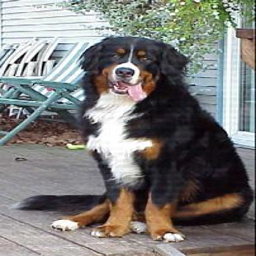

In [1]:
import datasets
import torchvision.transforms.functional as TF
from PIL import Image

dataset = datasets.load_dataset("Alanox/stanford-dogs", split="full")
img = dataset[9000]["image"]
img = img.resize((256,256))
img

# Compression

In [2]:
img = TF.to_tensor(img)
img.shape

torch.Size([3, 256, 256])

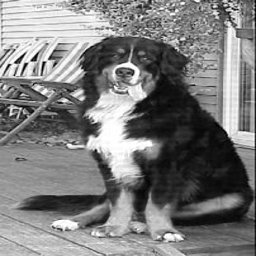

In [3]:
img1 = img[0,...]
TF.to_pil_image(img1)

In [4]:
import torch
import numpy as np

U,S_hat,V = torch.svd(img1)
U.shape, S_hat.shape, V.shape

(torch.Size([256, 256]), torch.Size([256]), torch.Size([256, 256]))

torch.Size([256, 10]) torch.Size([10]) torch.Size([10, 256])
torch.Size([256, 256])


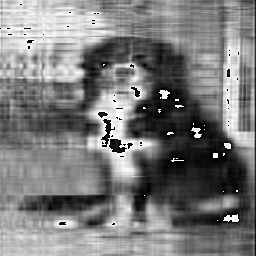

In [5]:
k = 10

# (256,k) x k x (kx256) = (256,256)
print(U[...,:k].shape, S_hat[:k].shape, V[...,:k].T.shape)

R = U[...,:k] @ torch.diag(S_hat[:k]) @ V[...,:k].T
print(R.shape)

TF.to_pil_image(R)

# Covariance / SVD for large tensors

In [6]:
imgs = dataset.select(np.random.choice(len(dataset), 200))

size = 16

def resize(batch):
    batch["image"] = batch["image"].resize((size,size))
    return batch
imgs = imgs.map(resize)
imgs = imgs.with_format("pt")["image"] / 255
imgs_f = imgs.flatten(start_dim=1)
imgs_f.shape, imgs_f.min(), imgs_f.max()

Map:  32%|███▏      | 63/200 [00:00<00:00, 298.71 examples/s]

Map: 100%|██████████| 200/200 [00:00<00:00, 278.68 examples/s]


(torch.Size([200, 768]), tensor(0.), tensor(1.))

In [7]:
imgs_mean = imgs_f.mean(dim=0)
imgs_f -= imgs_mean
imgs_f.min(), imgs_f.max()

(tensor(-0.5217), tensor(0.6546))

In [8]:
from pathlib import Path
from torch.linalg import eigh, inv

from tqdm import tqdm

cache_p = Path() / ".cache"
cache_p.mkdir(exist_ok=True)

imgs_t = imgs_f.T
window_size = 2800 # Cuda matrix capacity

def cov(X:torch.Tensor,Y:torch.Tensor):
    # X (S, N)
    # Y (S, N)
    ex_n = X.shape[1]

    return ((X - X.mean(dim=1).unsqueeze(dim=1)) @ (Y - Y.mean(dim=1).unsqueeze(dim=1)).T) / (ex_n - 1) # (S, S)

imgs_t_1 = imgs_t.cuda()
S = torch.zeros(imgs_t.shape[0])

n = imgs_t.shape[0]

In [9]:
sqr_size = n // 8

In [10]:
U_disk = np.memmap(cache_p / "U.npy", dtype='float32', mode='w+', shape=(n,n))

for j, s2 in tqdm(enumerate(range(0, n, window_size)), total=n // window_size + 1):
    s2_u = s2 + window_size
    
    imgs_t_2 = imgs_t[s2:s2_u].cuda()

    # Covariance matrix (n,m)
    X = cov(imgs_t_1, imgs_t_2).cuda()

    if j == 0:

        print("COV(X,Y) = ",imgs_t_1.shape, imgs_t_2.shape)

        print("COV = ", X.shape)
        print(X[:4,:4])

    Us = torch.zeros(*X.shape)

    # Correlation matrix (m,m)
    X_corr = X.T @ X

    S_hat, V = eigh(X_corr)

    if j == 0:
        print(f"S={tuple(S_hat.shape)} V={tuple(V.shape)}")
    S_hat_i = inv(torch.diag(S_hat))

    if j == 0:
        print(f"Si={tuple(S_hat_i.shape)}")

    U_hat = X @ V @ S_hat_i # (n,m) (m,m) (m,m) => (n,m)

    #torch.save(U_hat, p / f"U_{j}.pt")
    U_disk[:, s2: s2_u] = U_hat.cpu()

    S[s2: s2_u] = S_hat

print("Sorting")
# Sort U according to S entries
sort_idx = reversed(S.argsort())
S = S[sort_idx]
U_disk = U_disk[:, sort_idx]
np.isnan(U_disk).any()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

COV(X,Y) =  torch.Size([768, 200]) torch.Size([768, 200])
COV =  torch.Size([768, 768])
tensor([[0.0790, 0.0728, 0.0683, 0.0748],
        [0.0728, 0.0763, 0.0722, 0.0696],
        [0.0683, 0.0722, 0.0792, 0.0657],
        [0.0748, 0.0696, 0.0657, 0.0807]], device='cuda:0')
S=(768,) V=(768, 768)
Si=(768, 768)
Sorting


False

In [50]:
# REAL

sub_img = imgs_t[:4,:4].cpu()

imgs_flat = sub_img.T.flatten(start_dim=1)
imgs_flat -= imgs_flat.mean(axis=0)
imgs_cov = imgs_flat.T.cov()

# Vector decomposition
# print("SVD...")
U,S,V = torch.svd(imgs_cov)

print("SVD ", list(S))
print("EIGH", list(reversed(sorted(eigh(imgs_cov)[0]))))
print("-"*20)

# SNAPSHOT
S_hats = torch.zeros(sub_img.shape[0])
for s2 in range(0, 4, 2):
    s2_u = s2 + 2
    im = sub_img[s2:s2_u]
    
    X = cov(sub_img, im)

    X_corr = X.T @ X

    S_hat, V = eigh(X_corr)

    #_, S_hat, V = torch.svd(X)

    S_hats[s2: s2_u] = S_hat.sqrt()

    # S_hat_i = inv(torch.diag(S_hat))

    # U_hat = X @ V @ S_hat_i # (n,m) (m,m) (m,m) => (n,m)

    # U_disk[:, s2: s2_u] = U_hat.cpu()

S_hats = S_hats[reversed(S_hats.argsort())]
list(S_hats)

SVD  [tensor(0.2211), tensor(0.0120), tensor(0.0059), tensor(1.8244e-12)]
EIGH [tensor(0.2211), tensor(0.0120), tensor(0.0059), tensor(-1.5838e-08)]
--------------------


[tensor(0.1913), tensor(0.1113), tensor(0.0059), tensor(0.0035)]

In [12]:
U_disk = np.memmap(cache_p /  "U.npy", dtype='float32', mode='r+', shape=(n,n))
e = 0.01

ZCA_disk = np.memmap(cache_p / "zca.npy", dtype='float32', mode='w+', shape=(n,n))

S_sqrt = torch.sqrt(S.cuda() + e)

for s1 in tqdm(range(0, n, sqr_size), total=n // sqr_size + 1):
    s1_w = s1 + sqr_size
    Sd_sqrt = torch.diag(S_sqrt[s1: s1_w])

    for s2 in range(0, n, sqr_size):
        s2_w = s2 + sqr_size

        u = torch.from_numpy(U_disk[s1:s1_w, s2: s2_w]).cuda()
        ut = torch.from_numpy(U_disk.T[s1:s1_w, s2: s2_w]).cuda()
        
        ZCA_disk[s1:s1_w, s2:s2_w] = (u @ Sd_sqrt @ ut).cpu()

np.isnan(ZCA_disk).any()

 89%|████████▉ | 8/9 [00:00<00:00, 524.54it/s]


False

torch.Size([16, 16, 3])


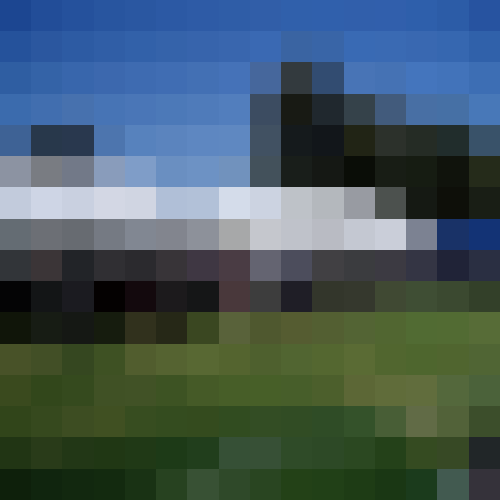

In [13]:
img1 = imgs[0].clone()
img1 += imgs_mean.view(img1.shape)
img1 = (img1 * 255).to(torch.uint8).cuda()
print(img1.shape)
TF.to_pil_image(img1.permute(2, 0, 1)).resize((500, 500), Image.Resampling.NEAREST)

In [14]:
ZCA_disk = np.memmap(cache_p / "zca.npy", dtype='float32', mode='r+', shape=(n,n))

def zca(imgs:torch.Tensor):
    shape = imgs.shape
    imgs = imgs.flatten(start_dim=1)

    imgs_zca = torch.zeros(imgs.T.shape)

    for s1 in tqdm(range(0, n, sqr_size)):
        s1_w = s1 + sqr_size

        imgs_zca[s1:s1_w] = (torch.tensor(ZCA_disk[s1:s1_w]).cuda() @ imgs.T)

    min = imgs_zca.min()
    min_max = imgs_zca.max() - min

    for s1 in tqdm(range(0, n, sqr_size)):
        s1_w = s1 + sqr_size

        scope = imgs_zca[s1:s1_w]

        imgs_zca[s1:s1_w] = (scope - min) / min_max
    
    return imgs_zca.T.view(shape)

zca_img = zca(img1.unsqueeze(dim=0) / 255)[0]
zca_img.shape

100%|██████████| 8/8 [00:00<00:00, 20323.70it/s]


torch.Size([16, 16, 3])

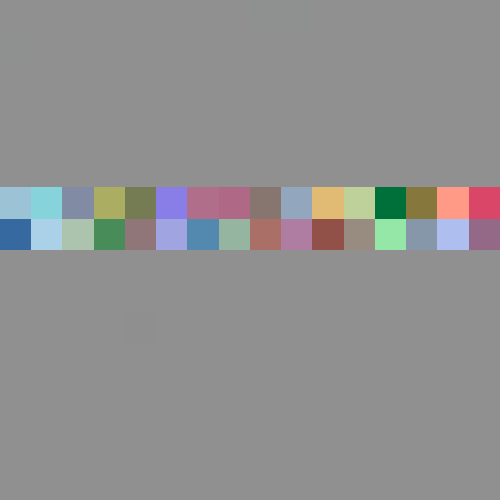

In [15]:
TF.to_pil_image(zca_img.permute(2, 0, 1)).resize((500,500), resample=Image.Resampling.NEAREST)

In [20]:
np.random.seed(0)
rand_idx = np.random.choice(range(len(dataset)), size=5000)
subset = dataset.select(rand_idx)

imgs_f = imgs_f.cpu()
img1 = img1.cpu()

imgs_flat = imgs_f.flatten(start_dim=1)
imgs_mean = imgs_flat.mean(axis=0)
imgs_flat -= imgs_mean
imgs_cov = imgs_flat.T.cov()
# Vector decomposition
print("SVD...")
U,S,V = torch.svd(imgs_cov)
e = 0.1

ZCA_mat = (U @ np.diag(1.0 / np.sqrt(S + e))) @ U.T
print("ZCA shape = ", ZCA_mat.shape)
zca_p = Path("").absolute().parent / "data/whitening"
zca_p.mkdir(exist_ok=True)
torch.save(ZCA_mat, zca_p / f"{size}.pt")

def zca(imgs:np.ndarray):
    print(imgs.shape)
    print(ZCA_mat.shape)
    shape = imgs.shape
    imgs = imgs.flatten(start_dim=1)
    imgs_zca = (ZCA_mat @ imgs.T).T
    imgs_zca = (imgs_zca - imgs_zca.min()) / (imgs_zca.max() - imgs_zca.min())
    return imgs_zca.view(shape)

imgs_zca = zca(img1.unsqueeze(dim=0) / 255)[0]
print(imgs_zca.shape)

SVD...
ZCA shape =  torch.Size([768, 768])
torch.Size([1, 16, 16, 3])
torch.Size([768, 768])
torch.Size([16, 16, 3])


In [21]:
U[0][:5]

tensor([-0.0575, -0.0167, -0.0213, -0.0447, -0.0688])

In [22]:
U_disk[0][:5]

memmap([ 2.5041747, 15.82357  ,  0.745475 ,  6.208991 ,  5.706327 ],
       dtype=float32)

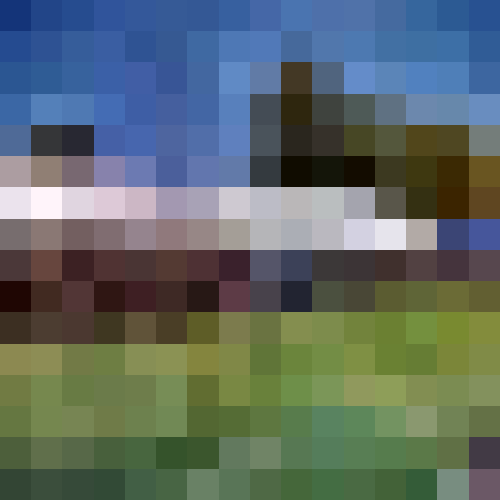

In [23]:
TF.to_pil_image(imgs_zca.permute(2, 0, 1)).resize((500,500), Image.Resampling.NEAREST)

# Maths

Snapshot calculation

$$\hat{X} = \hat{U}\hat{\Sigma}\hat{V}^{\smash{T}}$$

$$\hat{U} = X\hat{V}\hat{\Sigma}^{\smash{-1}}$$